In [3]:
import pandas as pd
import os
import re
import pdb
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import pdb
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import pickle
import random
from sklearn.manifold import TSNE

In [4]:
RANDOM_STATE = 13
sns.set(rc={'figure.figsize':(20,12)})
pd.options.mode.chained_assignment = None
np.random.seed(RANDOM_STATE)

In [63]:
# Read classifier weights
pth = "track_weights_few-shot-incremental-fine-tune_label_pull0.05.csv"
df = pd.read_csv(pth)
df

,episode,type,label,class,fine_tune_epoch,classifier_weight
0,0,base,house finch,house finch,1,[ 6.05582446e-03 -9.96689312e-03 -8.84426385e-...
1,0,base,robin,robin,1,[ 2.13238001e-02 -3.83395329e-02 -8.28482211e-...
2,0,base,triceratops,triceratops,1,[-8.09736401e-02 -4.61643152e-02 4.12433818e-...
3,0,base,green mamba,green mamba,1,[-4.15450223e-02 5.65156639e-02 -9.30255130e-...
4,0,base,harvestman,harvestman,1,[-1.04389824e-01 -9.95127950e-03 2.17748042e-...
...,...,...,...,...,...,...
2617,0,novel,poncho,poncho,38,[ 5.45121618e-02 1.02863451e-02 2.97710411e-...
2618,0,novel,miniskirt,miniskirt,38,[ 3.74940336e-02 4.16013971e-02 1.30085535e-...
2619,0,novel,white wolf,white wolf,38,[ 7.08241910e-02 3.35646980e-02 1.35516211e-...
2620,0,novel,garbage truck,garbage truck,38,[ 7.14595243e-02 -1.57763455e-02 1.66353248e-...


In [64]:
# Read label inspired weights
pth = "track_inspired_few-shot-incremental-fine-tune_label_pull0.05.csv"
df2 = pd.read_csv(pth)
df2

,episode,label,fine_tune_epoch,inspired_weight
0,0,poncho,1,[-5.97749129e-02 -3.43878306e-02 -1.65635236e-...
1,0,miniskirt,1,[-6.27260283e-02 -3.38583775e-02 -1.67556405e-...
2,0,white wolf,1,[-2.99560018e-02 2.46642917e-01 -7.87649751e-...
3,0,garbage truck,1,[-5.28937504e-02 -3.54182944e-02 -2.95007918e-...
4,0,missile,1,[ 4.00153026e-02 -4.96291630e-02 -2.14580260e-...
...,...,...,...,...
185,0,poncho,38,[-6.59986138e-02 -3.59287634e-02 -2.46047974e-...
186,0,miniskirt,38,[-6.89363256e-02 -3.53939645e-02 -2.49015056e-...
187,0,white wolf,38,[-3.07767168e-02 2.46302143e-01 -7.99025670e-...
188,0,garbage truck,38,[-6.43603802e-02 -3.76698449e-02 -3.18890698e-...


In [65]:
def label_point(x, y, val, ax, shift, novel_classes=None):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if novel_classes is None:
            novel=False
        else:
            novel = str(point['val']) in novel_classes
        ax.text(point['x']+shift, 
                point['y'], 
                str(point['val']), 
                color='g' if novel else 'black', alpha=0.6)

In [66]:
def parse_numpy(strarr):
    r = []
    for i in strarr.split():
        if i.strip() in ["[","]"]:
            continue
        else:
            try:
                r.append(float(i.strip('[]')))
            except:
                print(strarr)
                pdb.set_trace()
                
    return np.array(r)

In [67]:
def fit_plot_trajectory(episode, sample_base, novel_labels, new_df, method="pca", legend=False, label_shift=0.01):
    arr = list(new_df.loc[:,"classifier_weight"].copy().map(parse_numpy))
    X = np.stack(list(arr), axis=0)
    selected_classes = list(sample_base) + list(novel_labels)
    print(selected_classes)
    if method == "pca":
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        X_new = pca.fit_transform(X)

    elif method=="pls":
        plsr = PLSRegression(n_components=2, scale=False)  
        y = new_df.loc[:,'label'].astype("category").cat.codes
        plsr.fit(X, y)
        X_new = plsr.x_scores_
       
    elif method=="tsne":
        X_new = TSNE(random_state=RANDOM_STATE).fit_transform(X)
        
    new_df.loc[:,'feat1'] = X_new[:,0]
    new_df.loc[:,'feat2'] = X_new[:,1]

    new_df_selected_class = new_df.loc[(new_df.loc[:,'label'].isin(selected_classes)) & (new_df.loc[:,'fine_tune_epoch'] % 3 ==0 ),:]
    g = sns.scatterplot(data=new_df_selected_class, x="feat1", y="feat2", 
                        hue="label", size="fine_tune_epoch", style="attractor" if "attractor" in new_df.columns else None)
    label_mask = new_df_selected_class.fine_tune_epoch == new_df_selected_class.fine_tune_epoch.max()
    label_point(new_df_selected_class.feat1.loc[label_mask], 
                new_df_selected_class.feat2.loc[label_mask], 
                new_df_selected_class.label.loc[label_mask], 
                plt.gca(),
                label_shift,
                novel_labels)  
    
    plt.title(f'Trajectory of classifier weights using {method}')
    
    if not legend: 
        g.legend_.remove()

In [68]:
BASE_NUM = 45
EPISODE = 0
new_df = df.loc[df['episode'] == EPISODE,:]
base_labels = np.unique(new_df.loc[new_df['type']=="base", "label"])
sample_base = np.random.choice(base_labels, BASE_NUM, False)
novel_labels = np.unique(new_df.loc[new_df['type']=="novel", "label"])
print("Base classes are ", sample_base)
print("Novel classes are ", novel_labels)


Base classes are  ['chime' 'orange' 'street sign' 'komondor' 'three-toed sloth' 'clog'
 'cocktail shaker' 'frying pan' 'unicycle' 'ladybug' 'organ' 'consomme'
 'gordon setter' 'prayer rug' 'green mamba' 'tile roof' 'harvestman'
 'dishrag' 'reel' 'ashcan' 'yawl' 'hair slide' 'tank' 'beer bottle'
 'toucan' 'photocopier' 'slot' 'tibetan mastiff' 'robin' 'arctic fox'
 'lipstick' 'rock beauty' 'ear' 'hotdog' 'aircraft carrier' 'tobacco shop'
 'miniature poodle' 'bolete' 'saluki' 'cliff' 'barrel' 'boxer' 'dugong'
 'solar dish' 'spider web']
Novel classes are  ['garbage truck' 'miniskirt' 'missile' 'poncho' 'white wolf']


['chime', 'orange', 'street sign', 'komondor', 'three-toed sloth', 'clog', 'cocktail shaker', 'frying pan', 'unicycle', 'ladybug', 'organ', 'consomme', 'gordon setter', 'prayer rug', 'green mamba', 'tile roof', 'harvestman', 'dishrag', 'reel', 'ashcan', 'yawl', 'hair slide', 'tank', 'beer bottle', 'toucan', 'photocopier', 'slot', 'tibetan mastiff', 'robin', 'arctic fox', 'lipstick', 'rock beauty', 'ear', 'hotdog', 'aircraft carrier', 'tobacco shop', 'miniature poodle', 'bolete', 'saluki', 'cliff', 'barrel', 'boxer', 'dugong', 'solar dish', 'spider web', 'garbage truck', 'miniskirt', 'missile', 'poncho', 'white wolf']


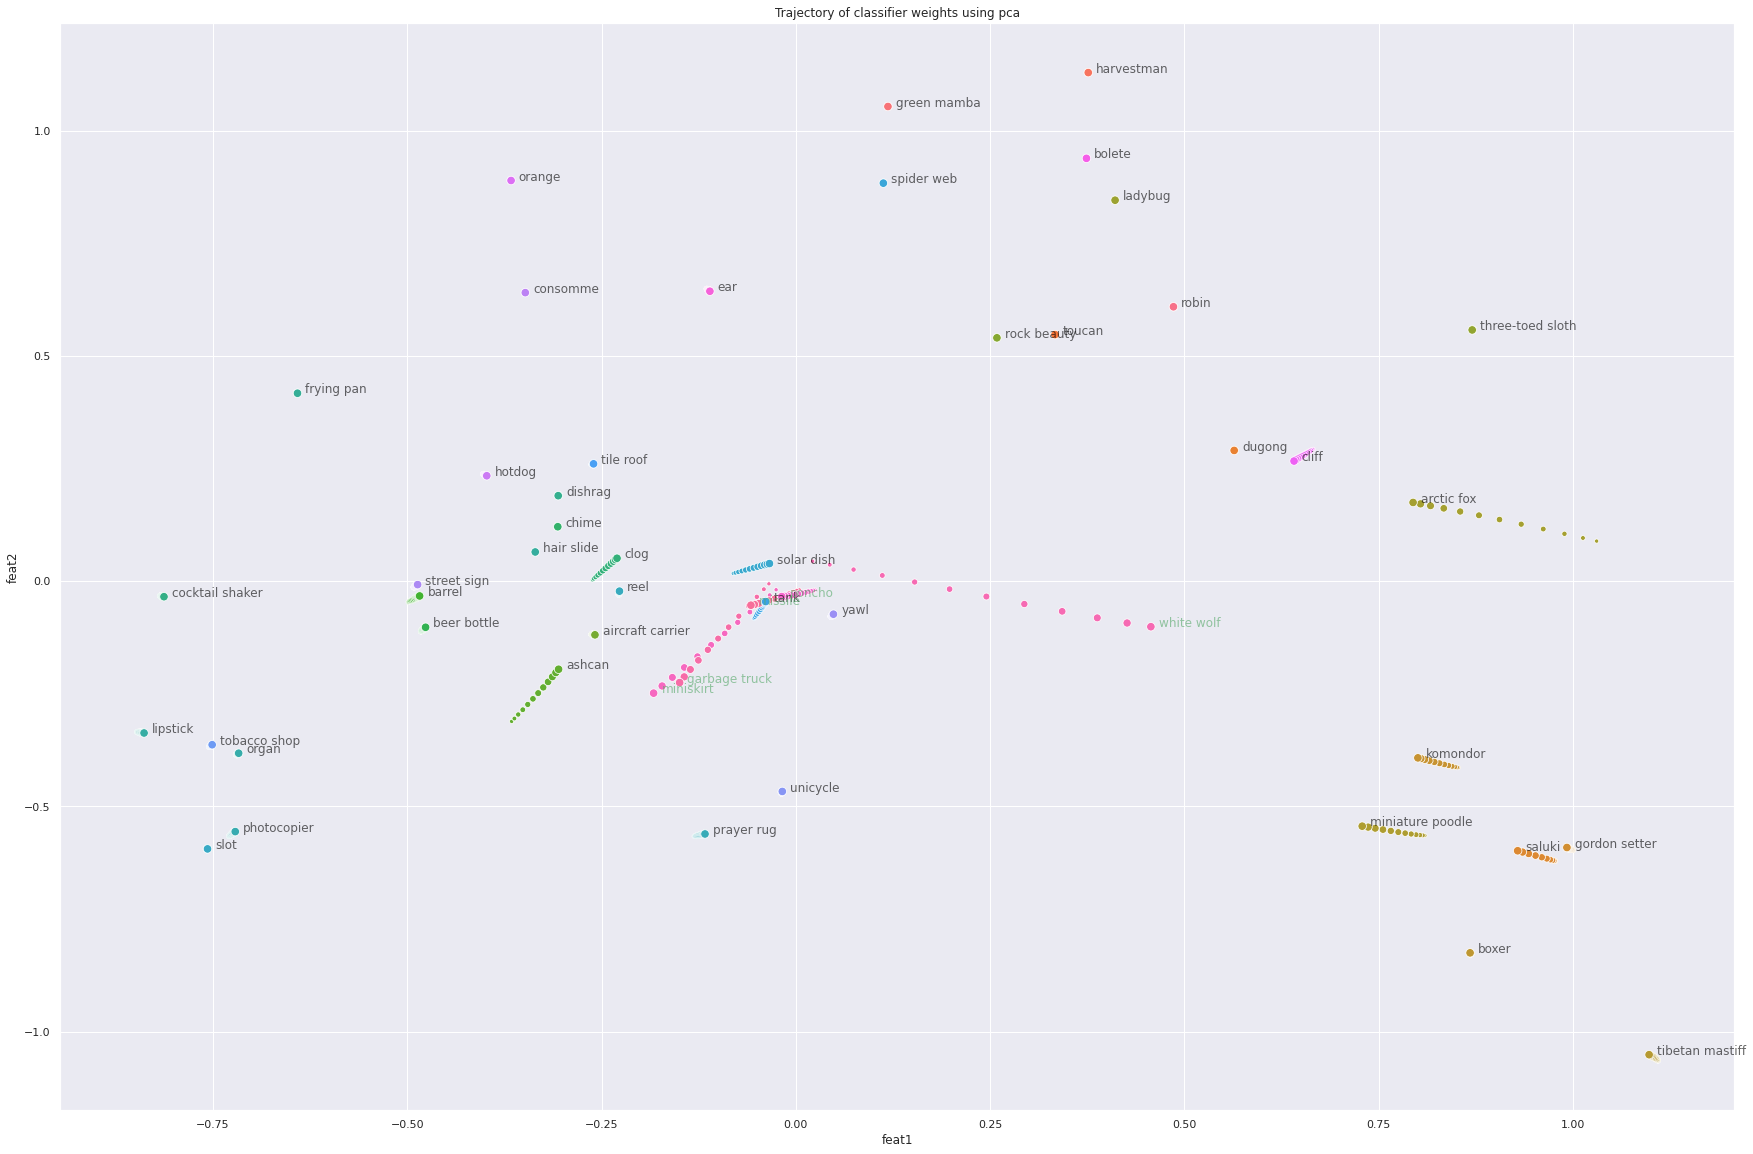

In [69]:
sns.set(rc={'figure.figsize':(30,20)})
fit_plot_trajectory(EPISODE, sample_base, novel_labels, new_df, "pca", legend=False)

['dugong', 'toucan', 'snorkel', 'rock beauty', 'saluki', 'triceratops', 'consomme', 'hair slide', 'robin', 'pencil box', 'tobacco shop', 'photocopier', 'dome', 'fire screen', 'clog', 'stage', 'street sign', 'miniature poodle', 'cliff', 'house finch', 'lipstick', 'oboe', 'komondor', 'upright', 'harvestman', 'tibetan mastiff', 'boxer', 'walker hound', 'cocktail shaker', 'spider web', 'beer bottle', 'three-toed sloth', 'frying pan', 'barrel', 'newfoundland', 'yawl', 'tank', 'worm fence', 'prayer rug', 'carousel', 'hotdog', 'ear', 'arctic fox', 'tile roof', 'unicycle', 'dishrag', 'parallel bars', 'chime', 'jellyfish', 'file', 'ashcan', 'orange', 'reel', 'slot', 'holster', 'solar dish', 'gordon setter', 'aircraft carrier', 'bolete', 'french bulldog', 'ladybug', 'organ', 'wok', 'green mamba', 'garbage truck', 'miniskirt', 'missile', 'poncho', 'white wolf']


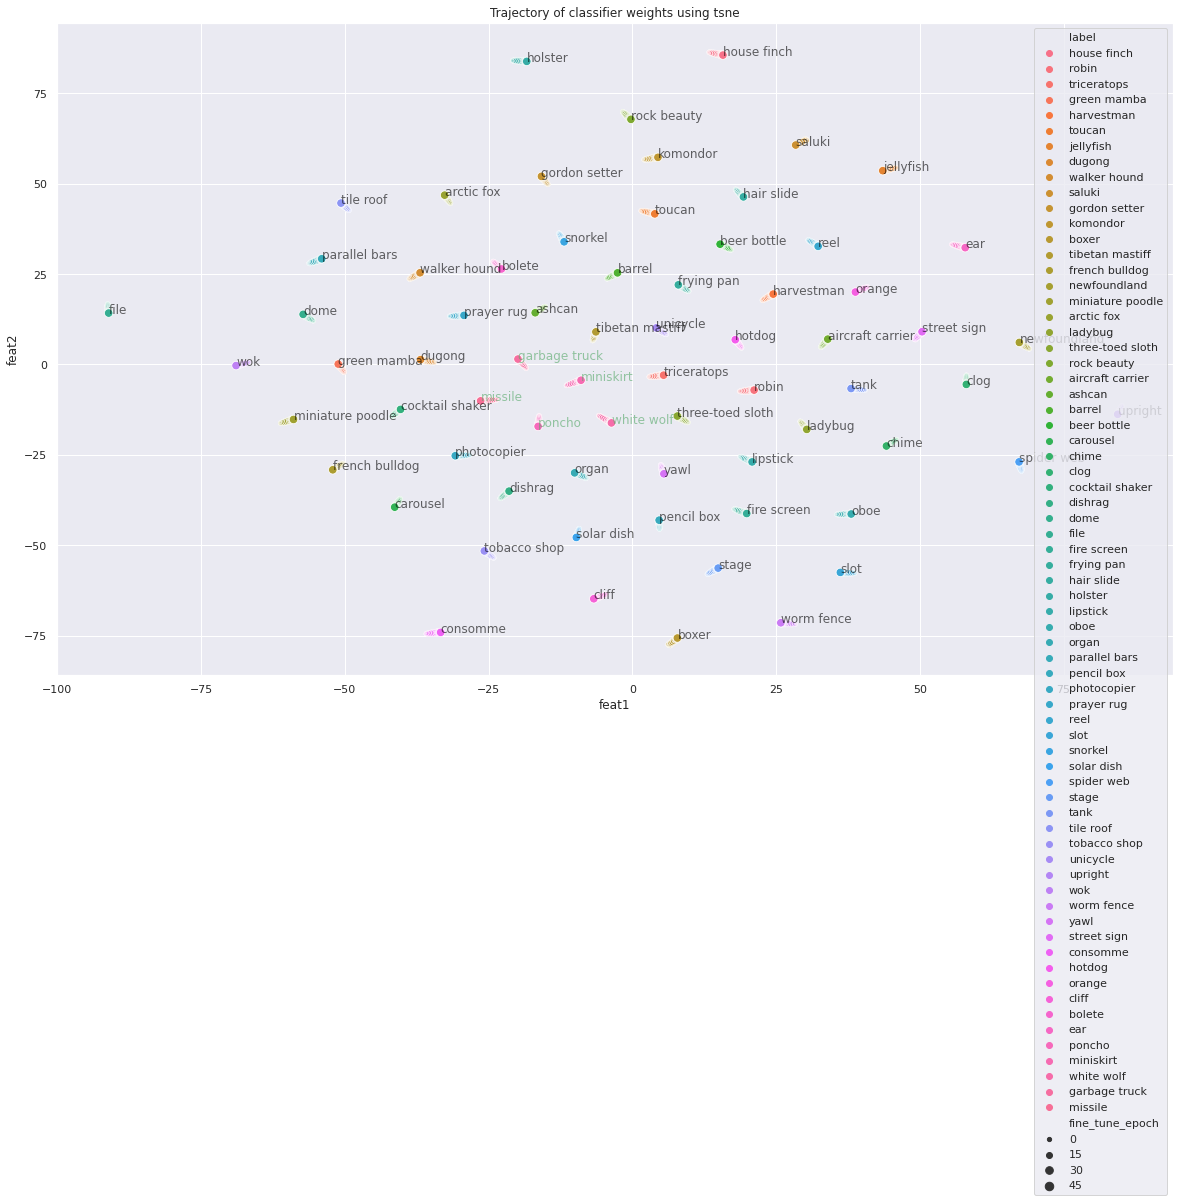

In [21]:
fit_plot_trajectory(EPISODE, sample_base, novel_labels, new_df, "tsne")

['dugong', 'toucan', 'snorkel', 'rock beauty', 'saluki', 'triceratops', 'consomme', 'hair slide', 'robin', 'pencil box', 'tobacco shop', 'photocopier', 'dome', 'fire screen', 'clog', 'stage', 'street sign', 'miniature poodle', 'cliff', 'house finch', 'lipstick', 'oboe', 'komondor', 'upright', 'harvestman', 'tibetan mastiff', 'boxer', 'walker hound', 'cocktail shaker', 'spider web', 'beer bottle', 'three-toed sloth', 'frying pan', 'barrel', 'newfoundland', 'yawl', 'tank', 'worm fence', 'prayer rug', 'carousel', 'hotdog', 'ear', 'arctic fox', 'tile roof', 'unicycle', 'dishrag', 'parallel bars', 'chime', 'jellyfish', 'file', 'ashcan', 'orange', 'reel', 'slot', 'holster', 'solar dish', 'gordon setter', 'aircraft carrier', 'bolete', 'french bulldog', 'ladybug', 'organ', 'wok', 'green mamba', 'garbage truck', 'miniskirt', 'missile', 'poncho', 'white wolf']


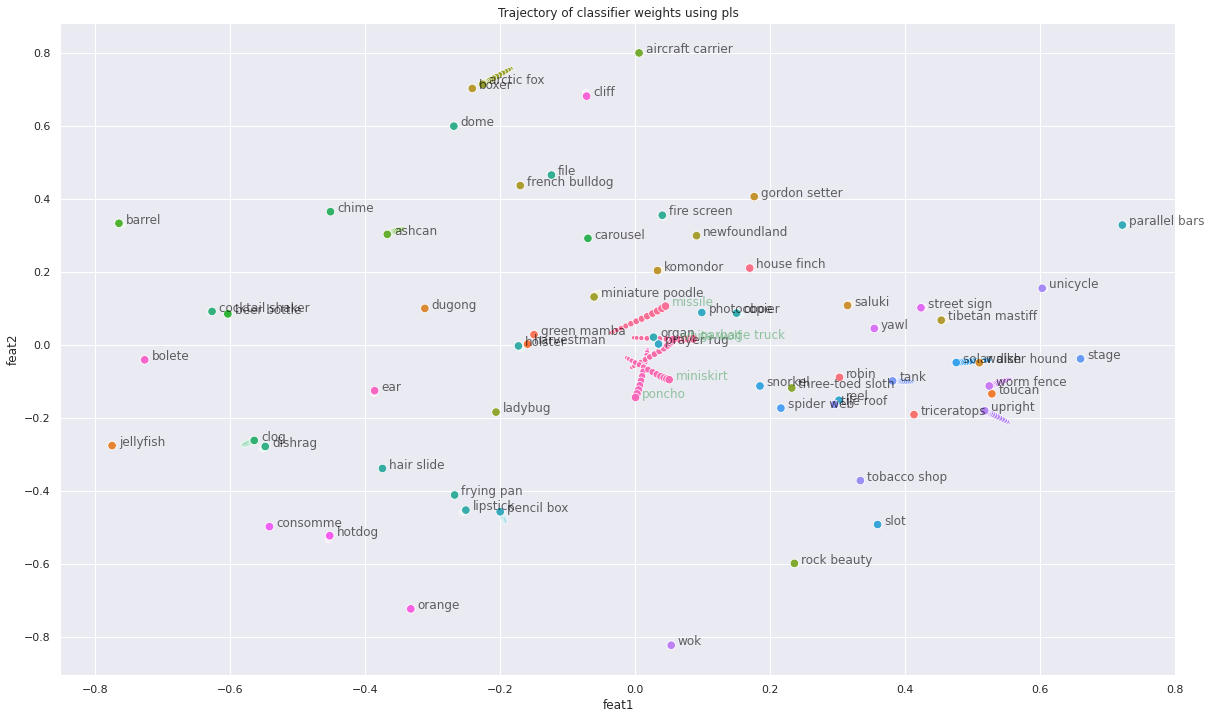

In [23]:
fit_plot_trajectory(EPISODE, sample_base, novel_labels, new_df, "pls")

In [70]:
new_df = df.loc[df['episode'] == EPISODE,:]
new_df2 = df2.loc[df2['episode'] == EPISODE,:]
new_df2.columns = list(new_df2.columns[:-1]) + ["classifier_weight"]
new_df['attractor'] = 0
new_df2['attractor'] = 1

merged = pd.concat([new_df, new_df2])


base_labels = np.unique(new_df.loc[new_df['type']=="base", "label"])
sample_base = np.random.choice(base_labels, BASE_NUM, False)
novel_labels = np.unique(new_df.loc[new_df['type']=="novel", "label"])
print("Base classes are ", sample_base)
print("Novel classes are ", novel_labels)

Base classes are  ['solar dish' 'hair slide' 'saluki' 'boxer' 'tibetan mastiff'
 'gordon setter' 'french bulldog' 'cliff' 'tobacco shop' 'file' 'dome'
 'fire screen' 'cocktail shaker' 'house finch' 'walker hound'
 'aircraft carrier' 'prayer rug' 'lipstick' 'holster' 'ladybug'
 'frying pan' 'harvestman' 'chime' 'street sign' 'stage' 'snorkel'
 'toucan' 'beer bottle' 'spider web' 'green mamba' 'barrel' 'triceratops'
 'tile roof' 'parallel bars' 'three-toed sloth' 'jellyfish' 'bolete'
 'tank' 'dishrag' 'yawl' 'newfoundland' 'upright' 'arctic fox'
 'miniature poodle' 'oboe']
Novel classes are  ['garbage truck' 'miniskirt' 'missile' 'poncho' 'white wolf']


['solar dish', 'hair slide', 'saluki', 'boxer', 'tibetan mastiff', 'gordon setter', 'french bulldog', 'cliff', 'tobacco shop', 'file', 'dome', 'fire screen', 'cocktail shaker', 'house finch', 'walker hound', 'aircraft carrier', 'prayer rug', 'lipstick', 'holster', 'ladybug', 'frying pan', 'harvestman', 'chime', 'street sign', 'stage', 'snorkel', 'toucan', 'beer bottle', 'spider web', 'green mamba', 'barrel', 'triceratops', 'tile roof', 'parallel bars', 'three-toed sloth', 'jellyfish', 'bolete', 'tank', 'dishrag', 'yawl', 'newfoundland', 'upright', 'arctic fox', 'miniature poodle', 'oboe', 'garbage truck', 'miniskirt', 'missile', 'poncho', 'white wolf']


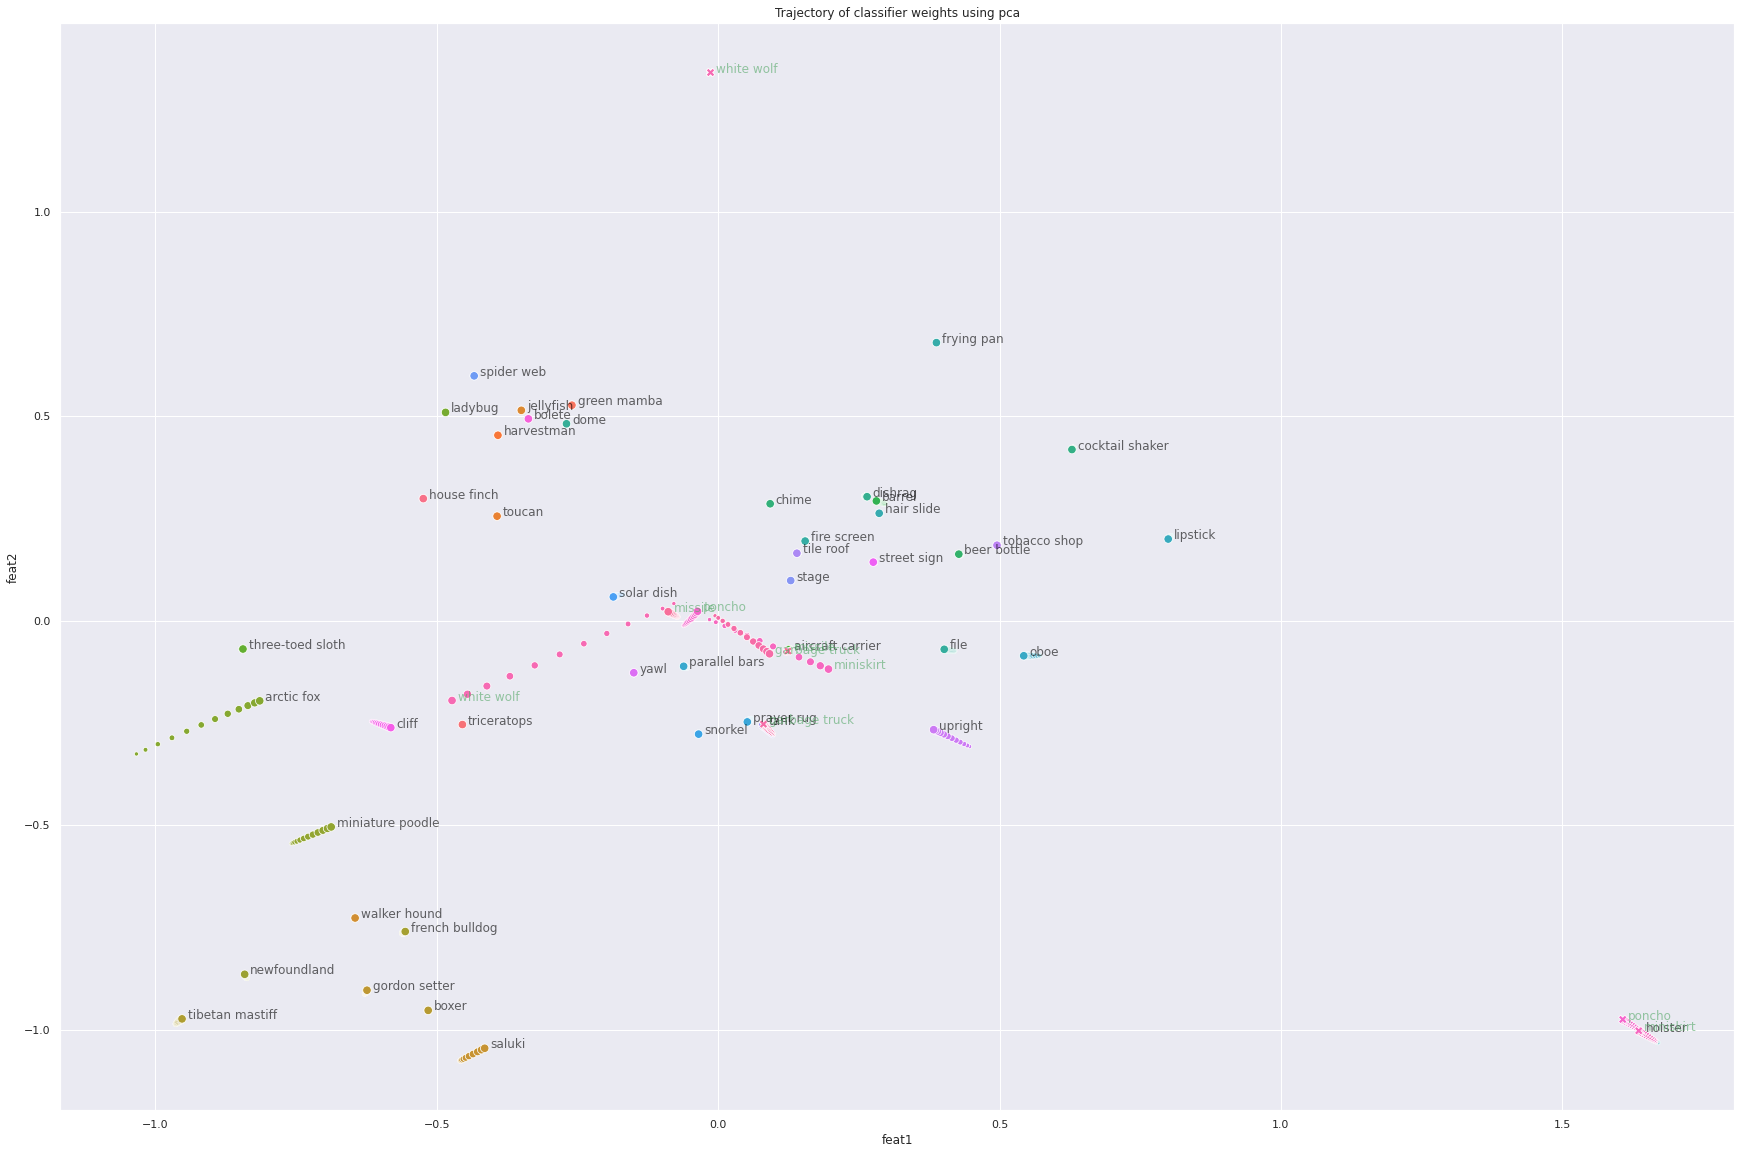

In [71]:
fit_plot_trajectory(EPISODE, sample_base, novel_labels, merged, "pca", legend=False)

In [24]:
file = os.path.join("description_embeds","miniImageNet_bert-base-cased_layer8_prefix_True.pickle")
# file = os.path.join("word_embeds","miniImageNet_dim500.pickle")
with (open(file, "rb")) as openfile:
    embeds = pickle.load(openfile)
vocab = list(embeds.keys())
arr = []
for cls in vocab:
    arr.append(embeds[cls])
X = np.stack(list(arr), axis=0)

In [72]:
def plot_labels(X, selected_classes, sample_base, novel_labels, method="pca", legend=True, label_shift=0.01):
    if method == "pca":
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        X_new = pca.fit_transform(X)

    elif method=="pls":
        plsr = PLSRegression(n_components=2, scale=False)  
        y = [i for i,_ in enumerate(selected_classes)]
        plsr.fit(X, y)
        X_new = plsr.x_scores_
       
    elif method=="tsne":
        X_new = TSNE().fit_transform(X)
    
    new_df = pd.DataFrame({"feat1":X_new[:,0], "feat2":X_new[:,1], "label":selected_classes})
    ax = sns.scatterplot(data=new_df, x="feat1", y="feat2", hue="label")
    if not legend: 
        ax.legend_.remove()    
    label_point(new_df.feat1, new_df.feat2, new_df.label, plt.gca(), shift=label_shift)  
    plt.title(f'Label embeddings using {method}')
    
    

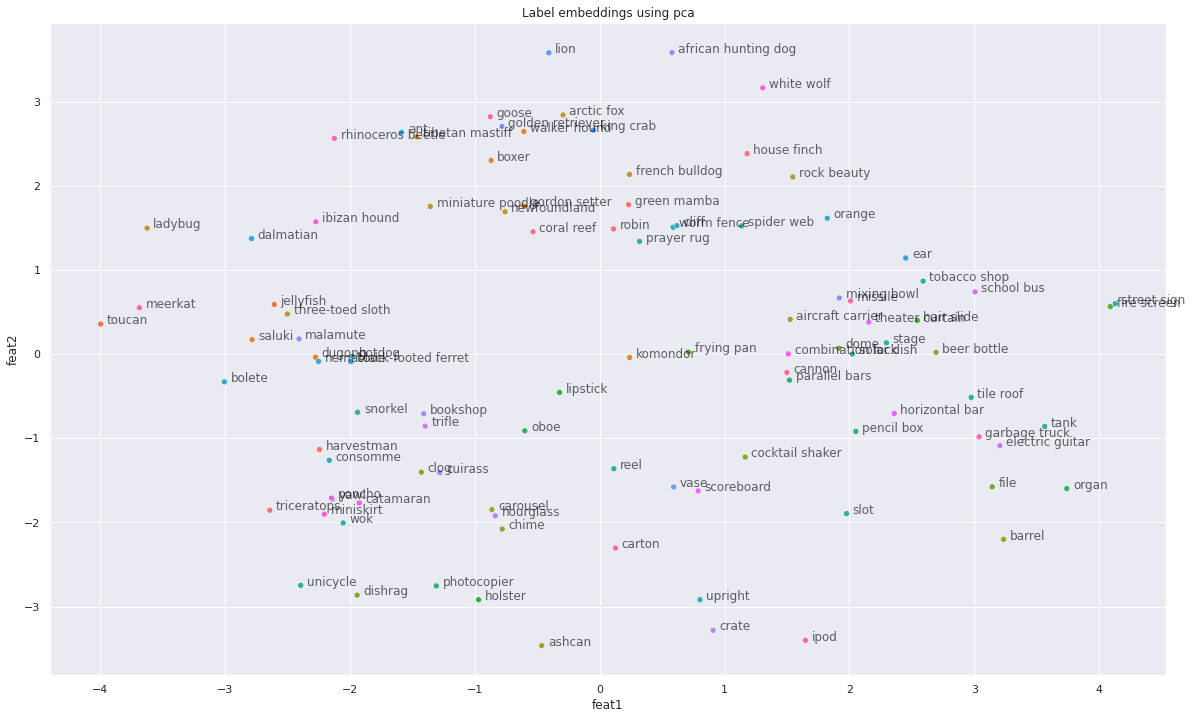

In [74]:
plot_labels(X, vocab, sample_base, novel_labels, label_shift = 0.05, legend=False)

In [63]:
file = os.path.join("word_embeds","miniImageNet_dim500.pickle")
with (open(file, "rb")) as openfile:
    embeds = pickle.load(openfile)
embed_tensor = [0] * len(vocab)
for (i,token) in enumerate(vocab):
    words = token.split(' ')
    for w in words:
        try:
            embed_tensor[i] += embeds[w]
        except KeyError:
            embed_tensor[i] = np.zeros(500)
    embed_tensor[i] /= len(words)
X = np.stack(embed_tensor, axis=0)

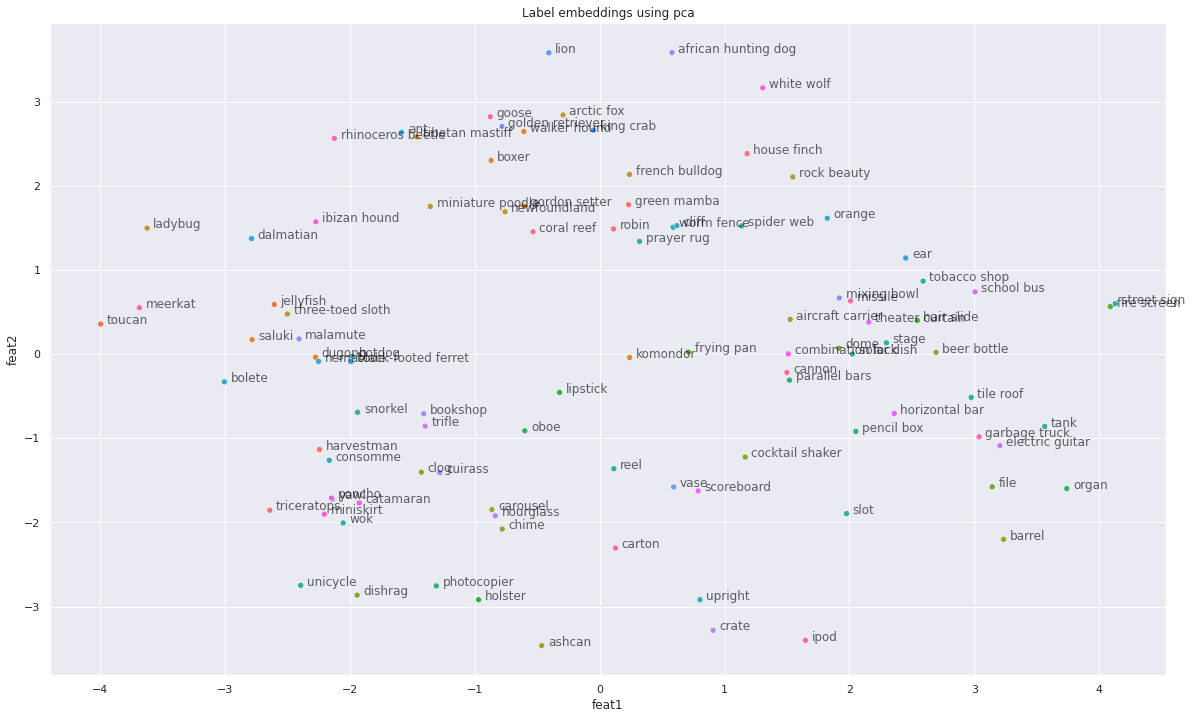

In [75]:
plot_labels(X, vocab, sample_base, novel_labels, label_shift = 0.05, legend=False)

In [97]:
GLOVE=True
file = os.path.join("word_embeds","miniImageNet_dim500.pickle")
with (open(file, "rb")) as openfile:
    embeds = pickle.load(openfile)
embed_tensor = [0] * len(vocab)
for (i,token) in enumerate(vocab):
    words = token.split(' ')
    for w in words:
        try:
            embed_tensor[i] += embeds[w]
        except KeyError:
            embed_tensor[i] = np.zeros(500)
    embed_tensor[i] /= len(words)

X = np.stack(embed_tensor, axis=0)
if GLOVE:
    X = X[:,:300]

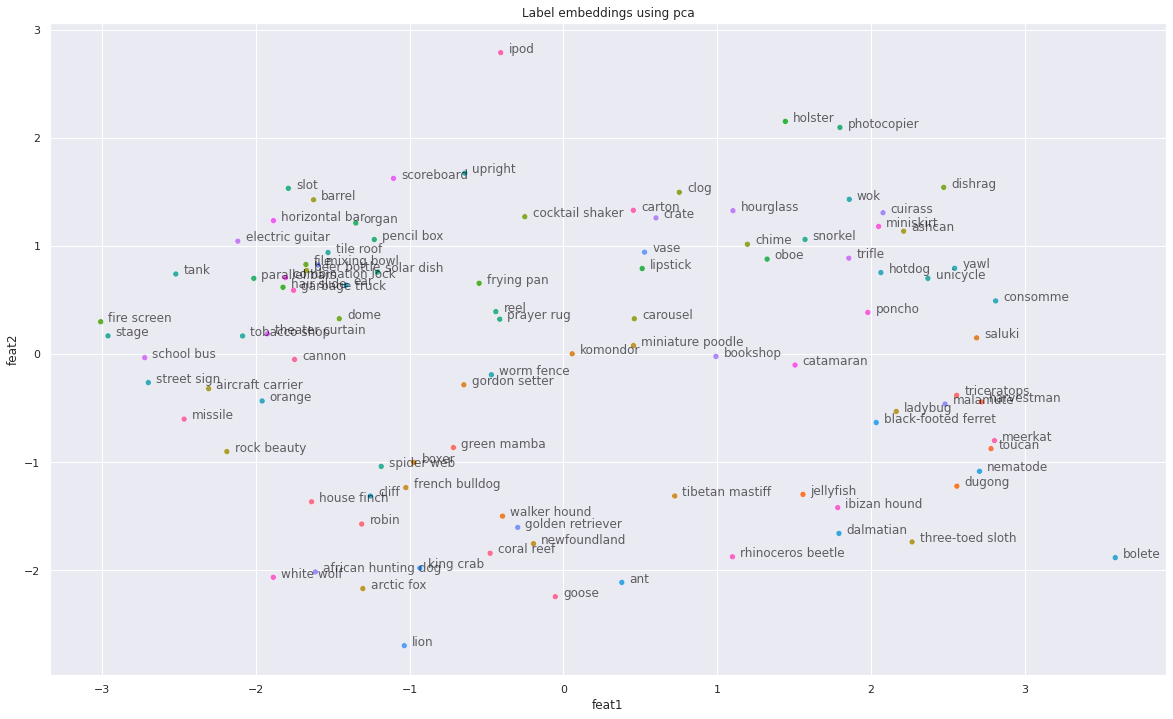

In [96]:
plot_labels(X, vocab, sample_base, novel_labels, label_shift = 0.05, legend=False)

In [77]:
sorted(vocab)

['african hunting dog',
 'aircraft carrier',
 'ant',
 'arctic fox',
 'ashcan',
 'barrel',
 'beer bottle',
 'black-footed ferret',
 'bolete',
 'bookshop',
 'boxer',
 'cannon',
 'carousel',
 'carton',
 'catamaran',
 'chime',
 'cliff',
 'clog',
 'cocktail shaker',
 'combination lock',
 'consomme',
 'coral reef',
 'crate',
 'cuirass',
 'dalmatian',
 'dishrag',
 'dome',
 'dugong',
 'ear',
 'electric guitar',
 'file',
 'fire screen',
 'french bulldog',
 'frying pan',
 'garbage truck',
 'golden retriever',
 'goose',
 'gordon setter',
 'green mamba',
 'hair slide',
 'harvestman',
 'holster',
 'horizontal bar',
 'hotdog',
 'hourglass',
 'house finch',
 'ibizan hound',
 'ipod',
 'jellyfish',
 'king crab',
 'komondor',
 'ladybug',
 'lion',
 'lipstick',
 'malamute',
 'meerkat',
 'miniature poodle',
 'miniskirt',
 'missile',
 'mixing bowl',
 'nematode',
 'newfoundland',
 'oboe',
 'orange',
 'organ',
 'parallel bars',
 'pencil box',
 'photocopier',
 'poncho',
 'prayer rug',
 'reel',
 'rhinoceros bee

In [196]:
plsr = PLSRegression(n_components=2, scale=False)
y = [i for i,_ in enumerate(selected_classes)]
plsr.fit(X, y)
X_new = plsr.x_scores_
new_df = pd.DataFrame({"feat1":X_new[:,0], "feat2":X_new[:,1], "label":selected_classes})

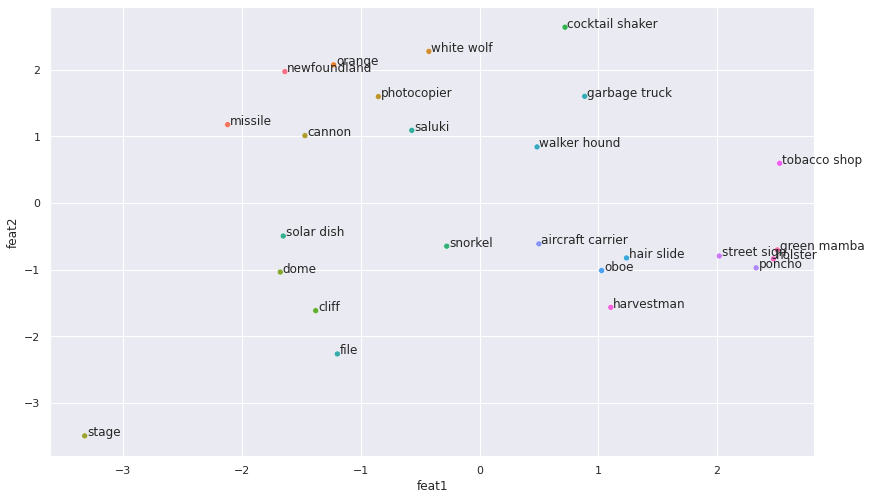

In [201]:
ax = sns.scatterplot(data=new_df, x="feat1", y="feat2", hue="label")
ax.legend_.remove()
label_point(new_df.feat1, new_df.feat2, new_df.label, plt.gca())  

In [207]:
file = os.path.join("word_embeds","miniImageNet_dim500.pickle")
with (open(file, "rb")) as openfile:
    embeds = pickle.load(openfile)

In [208]:
vocab = np.unique(df['label'])

In [231]:
embed_tensor = [0] * len(vocab)
for (i,token) in enumerate(vocab):
    words = token.split(' ')
    for w in words:
        try:
            embed_tensor[i] += embeds[w]
        except KeyError:
            embed_tensor[i] = np.zeros(500)
    embed_tensor[i] /= len(words)

In [219]:
embed_tensor

[array([ 1.97720498e-01,  5.96200004e-02, -2.47810006e-01, -2.13870004e-01,
        -2.33795017e-01, -1.89685494e-01,  2.42204994e-01,  6.33040011e-01,
        -3.97719979e-01, -1.99955010e+00,  4.31665003e-01,  5.71184978e-02,
         2.11174369e-01, -9.91169989e-01, -6.55789971e-02,  3.19424987e-01,
         4.65934992e-01,  1.14272498e-01, -2.17124999e-01, -6.29180014e-01,
         7.47999549e-03, -8.53000134e-02,  5.97319961e-01,  2.57650018e-01,
        -4.38679993e-01, -1.30670503e-01, -2.84974992e-01,  4.74650040e-02,
        -1.60131991e-01,  2.00089991e-01,  1.69696003e-01, -2.83405006e-01,
         1.14048496e-01, -1.94720000e-01, -1.26895010e-01, -2.10818008e-01,
        -5.45149982e-01, -4.46614981e-01, -4.06049937e-03,  6.93880022e-01,
        -4.18744981e-01, -1.79328009e-01,  1.64704502e-01,  3.03674996e-01,
         3.84312510e-01, -1.84061497e-01,  4.21384990e-01, -2.36539990e-02,
         3.59730005e-01, -1.19121991e-01,  4.22415018e-01, -3.13289016e-01,
         1.0

In [232]:
embeds_X = np.stack(embed_tensor, axis=0)

In [234]:
plsr = PLSRegression(n_components=2, scale=False)
y = [i for i,_ in enumerate(vocab)]
plsr.fit(embeds_X, y)
X_new = plsr.x_scores_
new_df = pd.DataFrame({"feat1":X_new[:,0], "feat2":X_new[:,1], "label":vocab})

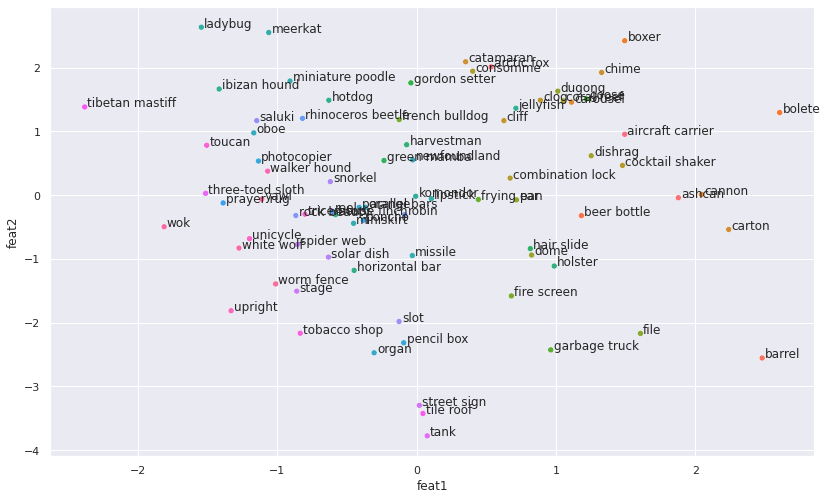

In [235]:
ax = sns.scatterplot(data=new_df, x="feat1", y="feat2", hue="label")
ax.legend_.remove()
label_point(new_df.feat1, new_df.feat2, new_df.label, plt.gca())  

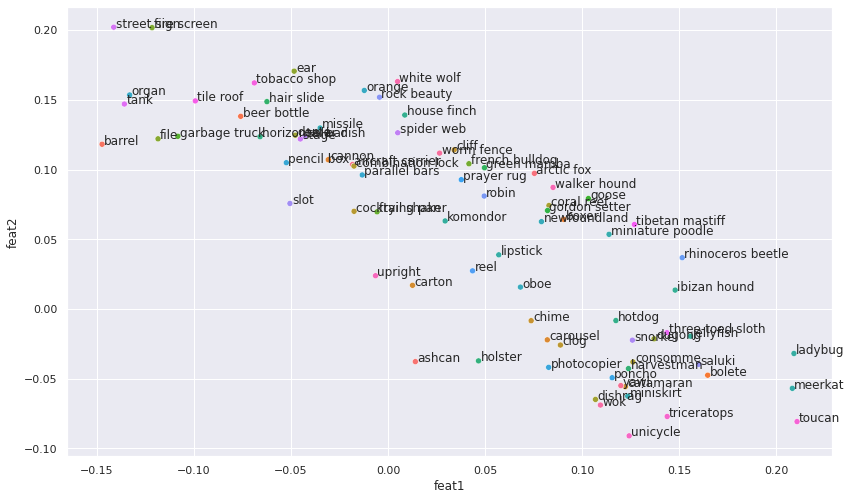

In [240]:
pca = PCA(n_components=2)
pca.fit(embeds_X)
X_pca = pca.transform(embeds_X)
X_new = pca.inverse_transform(X_pca)
new_df = pd.DataFrame({"feat1":X_new[:,0], "feat2":X_new[:,1], "label":vocab})
new_df.loc[:,'feat1'] = X_new[:,0]
new_df.loc[:,'feat2'] = X_new[:,1]



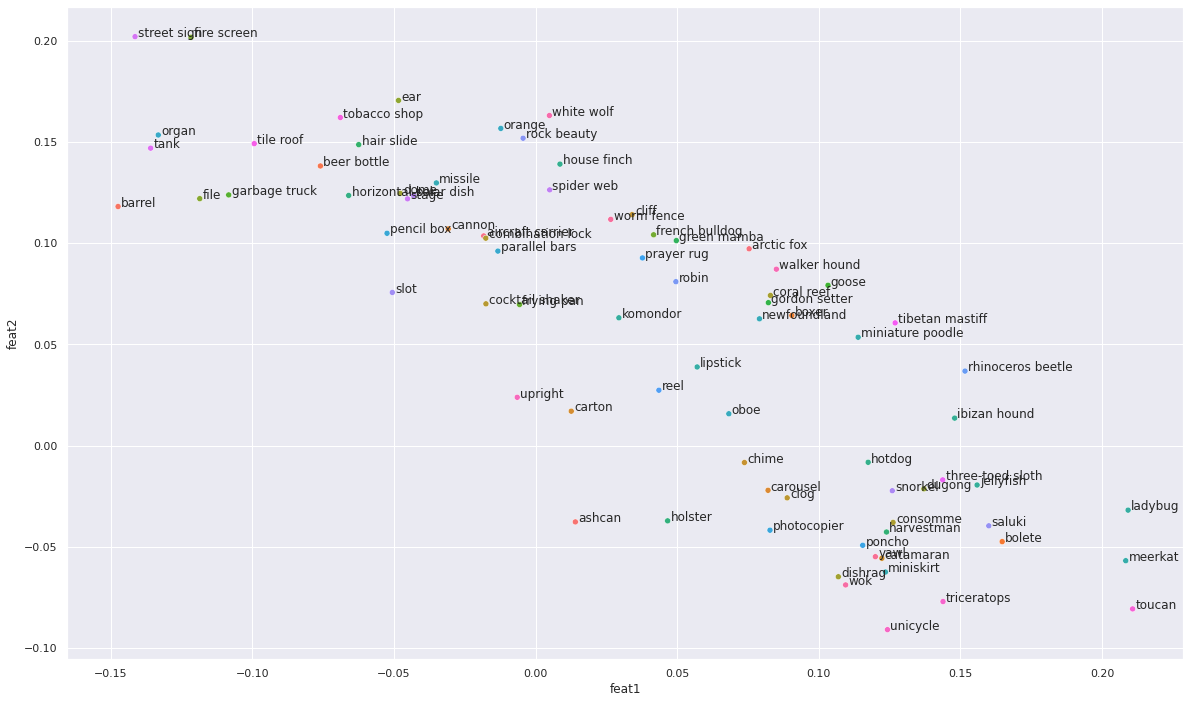

In [243]:
sns.set(rc={'figure.figsize':(20,12)})
ax = sns.scatterplot(data=new_df, x="feat1", y="feat2", hue="label")
ax.legend_.remove()
label_point(new_df.feat1, new_df.feat2, new_df.label, plt.gca(), shift=0.001) 

In [246]:
X_new = TSNE().fit_transform(embeds_X)
new_df = pd.DataFrame({"feat1":X_new[:,0], "feat2":X_new[:,1], "label":vocab})
new_df.loc[:,'feat1'] = X_new[:,0]
new_df.loc[:,'feat2'] = X_new[:,1]

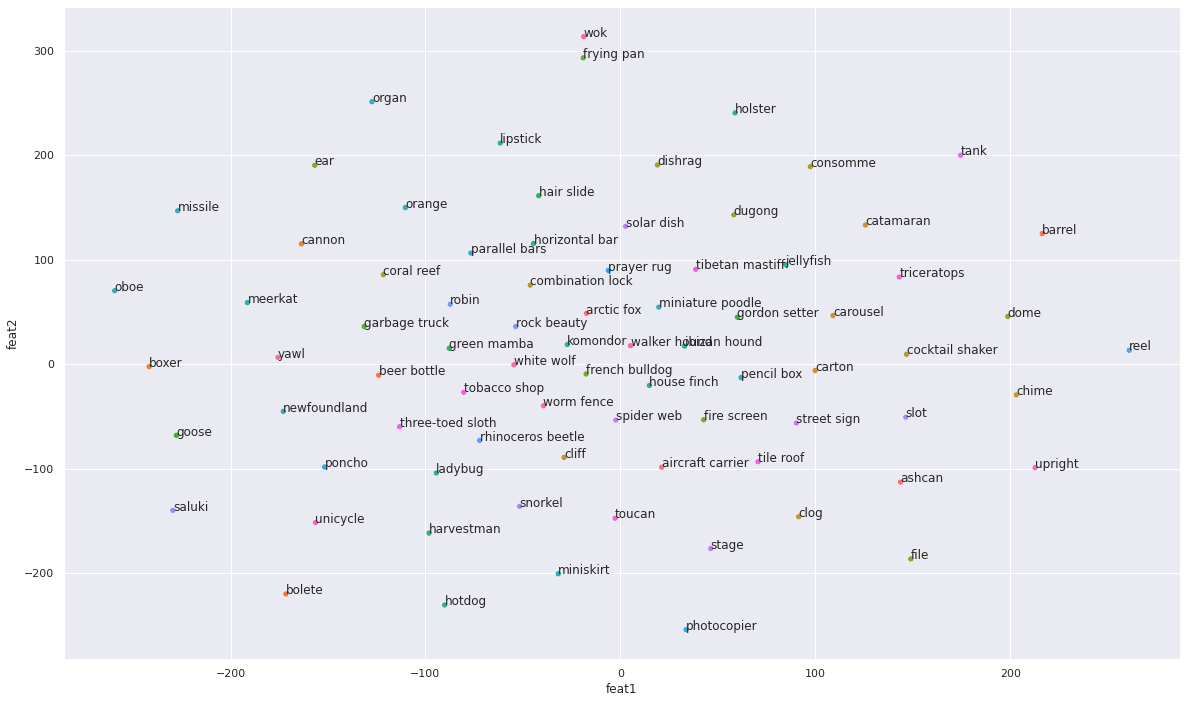

In [247]:
sns.set(rc={'figure.figsize':(20,12)})
ax = sns.scatterplot(data=new_df, x="feat1", y="feat2", hue="label")
ax.legend_.remove()
label_point(new_df.feat1, new_df.feat2, new_df.label, plt.gca(), shift=0.001) 